First, install the dependencies after setting up python venv with:
```
uv sync
```
and select the `.venv` as the kernel.

# 0. Trailers Inspection
Before we do anything, let's inspect our trailers for any metadata relevant for our presentation. We will:
- Print out all the names and the corresponding YouTube ID
- Print out the genres that movie belongs to

In [2]:
import pandas as pd
import json
import os
from pathlib import Path

# 1. Get all downloaded trailer files
trailers_dir = Path('/Users/danitniwat/Desktop/Workspaces/nlp_projektwoche/prelim_assign/data/trailers')
trailer_files = list(trailers_dir.glob('*.mp4'))
youtube_ids = [f.stem for f in trailer_files]

print(f"Found {len(trailer_files)} downloaded trailers:")
for youtube_id in youtube_ids:
    print(f"  - {youtube_id}.mp4")

# 2. Load metadata and sampled trailers data
print("\nLoading metadata...")
with open('data/metadata.json', 'r') as f:
    metadata = json.load(f)

sampled_df = pd.read_csv('data/sampled_trailers.csv')

# 3. Create reverse mapping: YouTube ID -> Database ID -> Movie Info
print("Creating mappings...")

# First, create YouTube ID to database ID mapping
youtube_to_db_id = {}
for db_id in metadata['trailers12k'].keys():
    try:
        yt_id = metadata['trailers12k'][db_id]['youtube']['trailers'][0]['id']
        youtube_to_db_id[yt_id] = db_id
    except (KeyError, IndexError):
        continue

# 4. Extract information for each downloaded trailer
trailer_info = []

for youtube_id in youtube_ids:
    if youtube_id in youtube_to_db_id:
        db_id = youtube_to_db_id[youtube_id]
        movie_data = metadata['trailers12k'][db_id]
        
        # Get IMDB ID (with 'tt' prefix for matching with sampled data)
        imdb_id_clean = movie_data['imdb']['id']
        imdb_id_full = f"tt{imdb_id_clean}"
        
        # Get movie title
        movie_title = movie_data['imdb']['title']
        
        # Get genre information from sampled_trailers.csv
        movie_row = sampled_df[sampled_df['mid'] == imdb_id_full]
        
        if not movie_row.empty:
            # Get all genres for this movie
            genre_columns = ['action', 'adventure', 'comedy', 'crime', 'drama', 
                           'fantasy', 'horror', 'romance', 'sci-fi', 'thriller']
            
            movie_genres = []
            for genre in genre_columns:
                if movie_row[genre].iloc[0] == 1:
                    movie_genres.append(genre)
            
            trailer_info.append({
                'youtube_id': youtube_id,
                'imdb_id': imdb_id_full,
                'movie_title': movie_title,
                'genres': movie_genres,
                'genre_string': ', '.join(movie_genres),
                'file_path': f'data/trailers/{youtube_id}.mp4'
            })
        else:
            print(f"Warning: Movie {imdb_id_full} not found in sampled data")
    else:
        print(f"Warning: YouTube ID {youtube_id} not found in metadata")

# 5. Display results
print(f"\n{'='*80}")
print("DOWNLOADED TRAILERS ANALYSIS")
print(f"{'='*80}")

# 6. Create a summary DataFrame
if trailer_info:
    summary_df = pd.DataFrame(trailer_info)
    print(f"\n{'='*80}")
    print("SUMMARY TABLE")
    print(f"{'='*80}")
    print(summary_df[['movie_title', 'youtube_id', 'imdb_id', 'genre_string']].to_string(index=False))
    
    # Save to CSV for easy reference
    # summary_df.to_csv('data/downloaded_trailers_summary.csv', index=False)
    print(f"\nSummary saved to: data/downloaded_trailers_summary.csv")
else:
    print("\nNo trailer information could be extracted.")

# 7. Genre distribution of downloaded trailers
if trailer_info:
    print(f"\n{'='*80}")
    print("GENRE DISTRIBUTION")
    print(f"{'='*80}")
    
    all_genres = []
    for info in trailer_info:
        all_genres.extend(info['genres'])
    
    genre_counts = pd.Series(all_genres).value_counts()
    print(genre_counts.to_string())

Found 24 downloaded trailers:
  - p-pVxwaFuBs.mp4
  - 5-_9AFwMDmQ.mp4
  - oMDXmDOyWE8.mp4
  - Yt7ofokzn04.mp4
  - VA7LT1hym1M.mp4
  - lioWzrpCtGQ.mp4
  - suJhUxvLUDE.mp4
  - hrt7uSLIiyk.mp4
  - Xj8FyGLhLwo.mp4
  - c4vCtn5RMKo.mp4
  - YdTqAevPejU.mp4
  - pBwcksgKcFs.mp4
  - LMkkJbRJdiA.mp4
  - 9scyo1fQXbc.mp4
  - UmkuYy5tbFM.mp4
  - MyiHqXGsD8c.mp4
  - QGerKfRYeq4.mp4
  - o-mGxa-_85M.mp4
  - jtnqVZEktyg.mp4
  - X_2hHR9W8uk.mp4
  - Fu75D5tvxBA.mp4
  - LSrBBhedXVE.mp4
  - MNQiLB2Rdjs.mp4
  - HXI_xAJFi4Q.mp4

Loading metadata...
Creating mappings...

DOWNLOADED TRAILERS ANALYSIS

SUMMARY TABLE
                           movie_title  youtube_id   imdb_id                            genre_string
                        Now You See Me p-pVxwaFuBs tt1670345                         crime, thriller
            Far from the Madding Crowd 5-_9AFwMDmQ tt2935476                          drama, romance
                 40 Days and 40 Nights oMDXmDOyWE8 tt0243736                         comedy, romance

# 1. Audio Extraction
First, let's extract the audio files from the movie trailers. Since our files are identified with YouTube IDs, we will use the same IDs to identify the sound files.

In [6]:
import ffmpeg
from tqdm import tqdm
from pathlib import Path

# Create output directory for WAV files if it doesn't exist
output_dir = Path('data/audio')
output_dir.mkdir(parents=True, exist_ok=True)

# Process each trailer file
for trailer_file in tqdm(trailer_files):
    # Get the YouTube ID from the filename (without .mp4 extension)
    youtube_id = trailer_file.stem
    
    # Define input and output paths
    input_file = str(trailer_file)
    output_file = str(output_dir / f"{youtube_id}.wav")
    
    try:
        # Create the FFmpeg command
        stream = ffmpeg.input(input_file)
        stream = ffmpeg.output(stream, output_file,
                             acodec='pcm_s16le',  # Audio codec
                             ar=16000,           # Sample rate
                             ac=1,               # Number of audio channels
                             vn=None)            # Disable video
        
        # Run the command
        ffmpeg.run(stream)
        print(f"Successfully processed {youtube_id}")
        
    except ffmpeg.Error as e:
        print(f"Error processing {youtube_id}: {e.stderr.decode()}")

  0%|          | 0/24 [00:00<?, ?it/s]ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb 

Successfully processed p-pVxwaFuBs


[out#0/wav @ 0x14fe11930] video:0KiB audio:4788KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.001591%
size=    4788KiB time=00:02:33.20 bitrate= 256.0kbits/s speed=1.21e+03x    
  8%|▊         | 2/24 [00:15<02:20,  6.38s/it]ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwe

Successfully processed 5-_9AFwMDmQ
Successfully processed oMDXmDOyWE8


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed Yt7ofokzn04
Successfully processed VA7LT1hym1M


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed lioWzrpCtGQ
Successfully processed suJhUxvLUDE


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed hrt7uSLIiyk
Successfully processed Xj8FyGLhLwo


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed c4vCtn5RMKo
Successfully processed YdTqAevPejU


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed pBwcksgKcFs
Successfully processed LMkkJbRJdiA


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed 9scyo1fQXbc
Successfully processed UmkuYy5tbFM


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed MyiHqXGsD8c


[out#0/wav @ 0x1280066a0] video:0KiB audio:2348KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.003244%
size=    2348KiB time=00:01:15.13 bitrate= 256.0kbits/s speed=1.15e+03x    
 71%|███████   | 17/24 [00:18<00:01,  4.95it/s]ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libw

Successfully processed QGerKfRYeq4
Successfully processed o-mGxa-_85M


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed jtnqVZEktyg
Successfully processed X_2hHR9W8uk


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed Fu75D5tvxBA
Successfully processed LSrBBhedXVE


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Successfully processed MNQiLB2Rdjs
Successfully processed HXI_xAJFi4Q


## 2. Extract Audio Features
Next, we will load the audio files and extract important features such as the tempo, MFCC, Chroma, Spectral Centroid, Zero Crossing Rate, and loudness for each trailer.

MFCC is Mel-frequency Cepstral Coefficients. It's a feature used in automatic speech and speaker recognition. It's a way to represent the short-term power spectrum of a sound which helps machines understand and process human speech more effectively (according to [geeksforgeeks](https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/)).

Chroma is an audio analysis that models the composition of spectrum bins through an FFT (Fast Fourier Transform) according to this [link](https://learn.flucoma.org/reference/chroma/).

Spectral Centroid is a weighted mean of the frequencies present in the signal determined using Fourier Transform with their magnituedes as weights according to [Wikipedia](https://en.wikipedia.org/wiki/Spectral_centroid). It is used to characterised the spectrum.

Zero Crossing Rate is the rate at which a signal changes from positive to zero to negative, or vice versa. It has been widely used in both speech recognition and music information retrieval, being a key feature to classify percussive sounds ([Wikipedia](https://en.wikipedia.org/wiki/Zero-crossing_rate)).


In [3]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

audio_dir = Path('data/audio')
audio_files = list(audio_dir.glob('*.wav'))

all_features = []

for audio_file in tqdm(audio_files):
    try:
        y, sr = librosa.load(audio_file) # sampling rate is already 16 kHz when we processed with ffmpeg
        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_centroid_mean = np.mean(spectral_centroid, axis=1)
        # Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
        zcr_mean = np.mean(zero_crossing_rate)
        # Loudness (RMS)
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        ### Combine all features into a dictionary
        features = {
            'filename': audio_file,
            'tempo': tempo,
            'spectral_centroid': spectral_centroid_mean,
            'zcr': zcr_mean,
            'rms': rms_mean,
            'genres': summary_df.loc[summary_df['youtube_id'] == audio_file.stem, 'genre_string'].values[0]
        }
        for i, val in enumerate(mfcc_mean):
            features[f'mfcc_{i+1}'] = val
        for i, val in enumerate(chroma_mean):
            features[f'chroma_{i+1}'] = val

        all_features.append(features)
        print(f"Successfully processed {audio_file}")
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

df = pd.DataFrame(all_features)
# df.to_csv('data/audio_features.csv', index=False)

  4%|▍         | 1/24 [00:08<03:23,  8.85s/it]

Successfully processed data/audio/YdTqAevPejU.wav


  8%|▊         | 2/24 [00:09<01:27,  3.98s/it]

Successfully processed data/audio/c4vCtn5RMKo.wav


 12%|█▎        | 3/24 [00:10<00:52,  2.48s/it]

Successfully processed data/audio/pBwcksgKcFs.wav


 17%|█▋        | 4/24 [00:10<00:33,  1.68s/it]

Successfully processed data/audio/LMkkJbRJdiA.wav


 21%|██        | 5/24 [00:11<00:24,  1.27s/it]

Successfully processed data/audio/MyiHqXGsD8c.wav


 25%|██▌       | 6/24 [00:11<00:16,  1.06it/s]

Successfully processed data/audio/UmkuYy5tbFM.wav


 29%|██▉       | 7/24 [00:12<00:14,  1.21it/s]

Successfully processed data/audio/9scyo1fQXbc.wav


 33%|███▎      | 8/24 [00:12<00:11,  1.43it/s]

Successfully processed data/audio/o-mGxa-_85M.wav


 38%|███▊      | 9/24 [00:12<00:09,  1.64it/s]

Successfully processed data/audio/QGerKfRYeq4.wav


 42%|████▏     | 10/24 [00:13<00:08,  1.74it/s]

Successfully processed data/audio/jtnqVZEktyg.wav


 46%|████▌     | 11/24 [00:13<00:06,  1.88it/s]

Successfully processed data/audio/HXI_xAJFi4Q.wav


 50%|█████     | 12/24 [00:14<00:06,  1.78it/s]

Successfully processed data/audio/MNQiLB2Rdjs.wav


 54%|█████▍    | 13/24 [00:15<00:06,  1.62it/s]

Successfully processed data/audio/LSrBBhedXVE.wav


 58%|█████▊    | 14/24 [00:15<00:06,  1.66it/s]

Successfully processed data/audio/Fu75D5tvxBA.wav


 62%|██████▎   | 15/24 [00:16<00:05,  1.71it/s]

Successfully processed data/audio/X_2hHR9W8uk.wav


 67%|██████▋   | 16/24 [00:16<00:04,  1.73it/s]

Successfully processed data/audio/p-pVxwaFuBs.wav


 71%|███████   | 17/24 [00:17<00:03,  1.79it/s]

Successfully processed data/audio/oMDXmDOyWE8.wav


 75%|███████▌  | 18/24 [00:18<00:03,  1.60it/s]

Successfully processed data/audio/5-_9AFwMDmQ.wav


 79%|███████▉  | 19/24 [00:18<00:03,  1.64it/s]

Successfully processed data/audio/VA7LT1hym1M.wav


 83%|████████▎ | 20/24 [00:19<00:02,  1.51it/s]

Successfully processed data/audio/Yt7ofokzn04.wav


 88%|████████▊ | 21/24 [00:20<00:02,  1.39it/s]

Successfully processed data/audio/lioWzrpCtGQ.wav


 92%|█████████▏| 22/24 [00:20<00:01,  1.46it/s]

Successfully processed data/audio/suJhUxvLUDE.wav


 96%|█████████▌| 23/24 [00:21<00:00,  1.53it/s]

Successfully processed data/audio/Xj8FyGLhLwo.wav


100%|██████████| 24/24 [00:21<00:00,  1.10it/s]

Successfully processed data/audio/hrt7uSLIiyk.wav


Then, we average the value of those features over the genre (each movie can have more than 1 genre) to capture the typical characteristic of each genre. Keep in mind that values such as RMS, spectral centroid, and tempo are scalar. However, the MFCC and Chroma are vectors.

In [4]:
# First we split genres into list
# import pandas as pd
# df = pd.read_csv('data/audio_features.csv')
df['genre_list'] = df['genres'].apply(lambda x: [g.strip() for g in x.split(',')])

# Explode so each genre gets its own row. This is easier to be averaged based on genres later.
df_exploded = df.explode('genre_list')
df_exploded

,filename,tempo,spectral_centroid,zcr,rms,genres,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,genre_list
0,data/audio/YdTqAevPejU.wav,[161.4990234375],[1234.518209050235],0.051482,0.074922,"crime, drama, sci-fi, thriller",-275.408295,130.523026,8.551910,58.072708,...,0.596690,0.599964,0.602959,0.555195,0.501745,0.542477,0.671879,0.601510,0.467282,crime
0,data/audio/YdTqAevPejU.wav,[161.4990234375],[1234.518209050235],0.051482,0.074922,"crime, drama, sci-fi, thriller",-275.408295,130.523026,8.551910,58.072708,...,0.596690,0.599964,0.602959,0.555195,0.501745,0.542477,0.671879,0.601510,0.467282,drama
0,data/audio/YdTqAevPejU.wav,[161.4990234375],[1234.518209050235],0.051482,0.074922,"crime, drama, sci-fi, thriller",-275.408295,130.523026,8.551910,58.072708,...,0.596690,0.599964,0.602959,0.555195,0.501745,0.542477,0.671879,0.601510,0.467282,sci-fi
0,data/audio/YdTqAevPejU.wav,[161.4990234375],[1234.518209050235],0.051482,0.074922,"crime, drama, sci-fi, thriller",-275.408295,130.523026,8.551910,58.072708,...,0.596690,0.599964,0.602959,0.555195,0.501745,0.542477,0.671879,0.601510,0.467282,thriller
1,data/audio/c4vCtn5RMKo.wav,[89.10290948275862],[1365.5048503894125],0.086580,0.028528,"comedy, drama, romance",-308.156250,122.216896,-16.063705,28.885965,...,0.364057,0.380663,0.340423,0.339663,0.423099,0.361696,0.412027,0.381994,0.397844,comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,data/audio/Xj8FyGLhLwo.wav,[143.5546875],[1494.8101474675452],0.083927,0.077363,"horror, sci-fi, thriller",-237.914124,127.367264,-9.521279,38.301224,...,0.391371,0.389313,0.421342,0.445137,0.454457,0.469436,0.465990,0.466542,0.518058,horror
22,data/audio/Xj8FyGLhLwo.wav,[143.5546875],[1494.8101474675452],0.083927,0.077363,"horror, sci-fi, thriller",-237.914124,127.367264,-9.521279,38.301224,...,0.391371,0.389313,0.421342,0.445137,0.454457,0.469436,0.465990,0.466542,0.518058,sci-fi
22,data/audio/Xj8FyGLhLwo.wav,[143.5546875],[1494.8101474675452],0.083927,0.077363,"horror, sci-fi, thriller",-237.914124,127.367264,-9.521279,38.301224,...,0.391371,0.389313,0.421342,0.445137,0.454457,0.469436,0.465990,0.466542,0.518058,thriller
23,data/audio/hrt7uSLIiyk.wav,[107.666015625],[1461.9824052897357],0.074983,0.200456,"drama, fantasy",-124.190887,147.157074,-27.016123,42.472763,...,0.317623,0.312277,0.288949,0.383098,0.391688,0.353309,0.320217,0.301788,0.436588,drama


In [5]:
# Select feature columns (exclude filename, genres, genre_list)
feature_cols = [col for col in df.columns if col not in ['filename', 'genres', 'genre_list']]

# Group by genre and calculate mean
df_avg = df_exploded.groupby('genre_list')[feature_cols].mean().reset_index()

df_avg

,genre_list,tempo,spectral_centroid,zcr,rms,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12
0,action,[124.36288435828878],[1614.8725297891626],0.090363,0.089993,-210.314178,125.160194,-30.875294,44.779716,-16.835392,...,0.421636,0.431324,0.420512,0.423462,0.421147,0.443839,0.429335,0.431670,0.455683,0.425768
1,adventure,[123.97904829545455],[1670.0221886409888],0.087155,0.069942,-225.721146,120.454468,-24.429781,45.254009,-17.478930,...,0.442157,0.420935,0.428595,0.422742,0.430831,0.425811,0.430328,0.461064,0.407086,0.391524
2,comedy,[130.30395407111038],[1760.7599904161843],0.095823,0.053118,-241.664490,122.601151,-30.631477,46.187584,-18.369783,...,0.431151,0.419330,0.430367,0.430396,0.435117,0.448367,0.435995,0.454043,0.425064,0.403464
3,crime,[147.66557173295456],[1573.350864706757],0.076802,0.076160,-230.509644,125.869553,-22.114851,51.315102,-13.494143,...,0.463065,0.462586,0.468932,0.487542,0.493500,0.473641,0.468546,0.505251,0.472417,0.431782
4,drama,[133.39005695116242],[1509.0743812503986],0.080991,0.078847,-244.038849,126.831673,-20.475630,43.729832,-14.275898,...,0.413838,0.406821,0.425891,0.423534,0.422245,0.428096,0.430099,0.462502,0.416622,0.403541
5,fantasy,[122.89151278409092],[1629.6941531514406],0.085081,0.112684,-182.914505,129.269409,-26.764755,42.726177,-18.059200,...,0.380999,0.386412,0.401671,0.372350,0.417521,0.432085,0.411747,0.413174,0.380018,0.405466
6,horror,[127.33871177449554],[1537.6141605332048],0.085244,0.166445,-154.900116,140.443802,-26.234093,41.116989,-15.794506,...,0.413555,0.428082,0.488167,0.438108,0.420835,0.439445,0.438435,0.470879,0.452816,0.516977
7,romance,[144.3264835993381],[1560.1925967002448],0.088109,0.040701,-286.045715,128.695999,-24.969086,39.800831,-11.762167,...,0.405104,0.392433,0.401088,0.426306,0.394881,0.445149,0.413972,0.450883,0.426805,0.383333
8,sci-fi,[133.836346652668],[1564.787954324012],0.087778,0.082127,-224.770538,129.411850,-22.849241,44.238739,-14.348557,...,0.409667,0.418945,0.448138,0.425905,0.415811,0.413565,0.427172,0.473793,0.450169,0.449706
9,thriller,[140.01599018919111],[1418.2386829229433],0.072776,0.082493,-238.096710,132.592804,-16.862095,42.845554,-9.772017,...,0.430908,0.463655,0.493291,0.481205,0.455109,0.466311,0.480732,0.491756,0.473663,0.482246


# 3. Analyzed Data Visualization
As the last step, let's plot the average values of tempo, spectral_centroid, zero crossing rate, and RMS (Loudness).

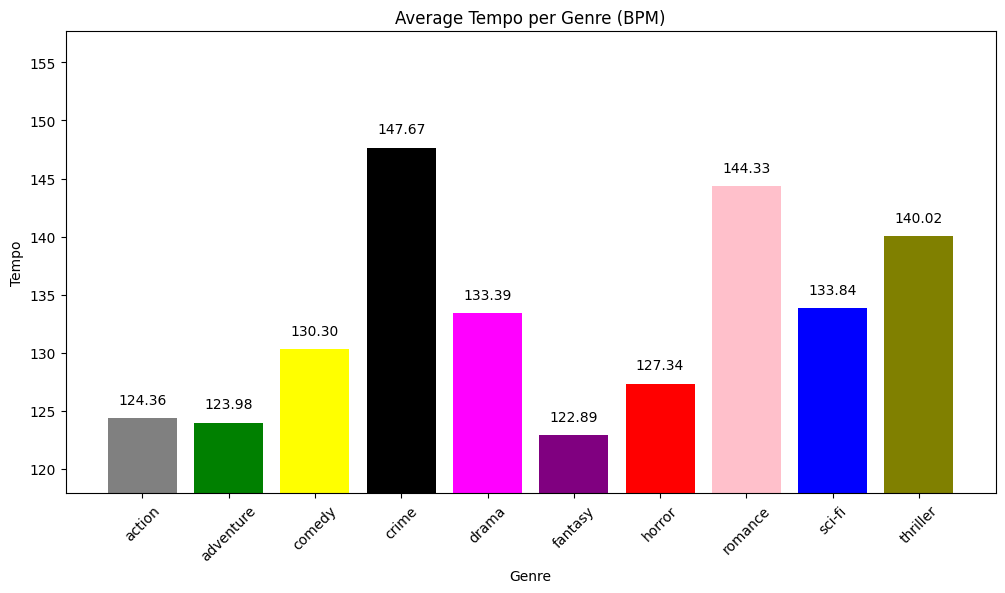

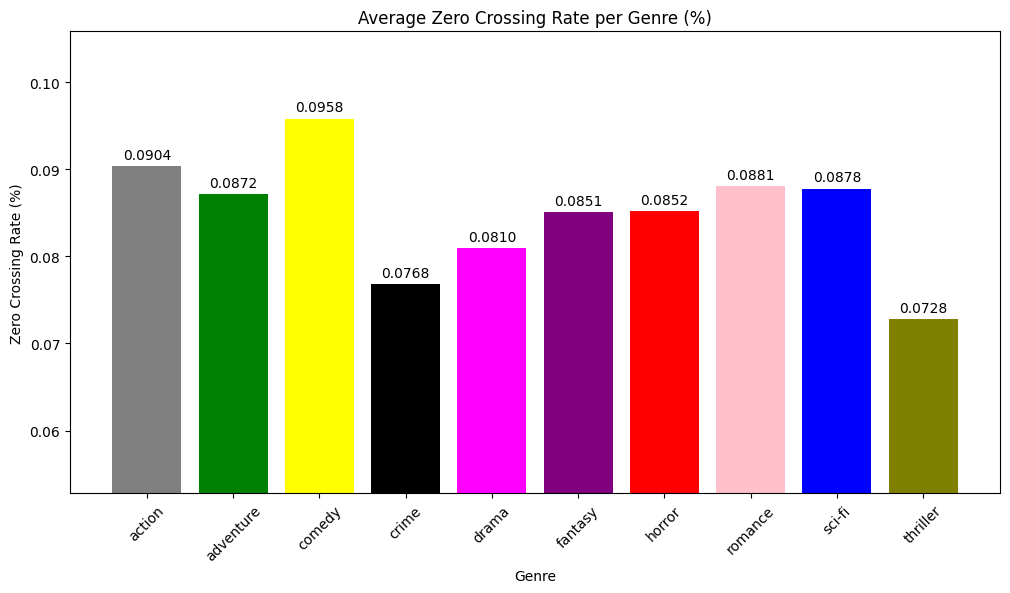

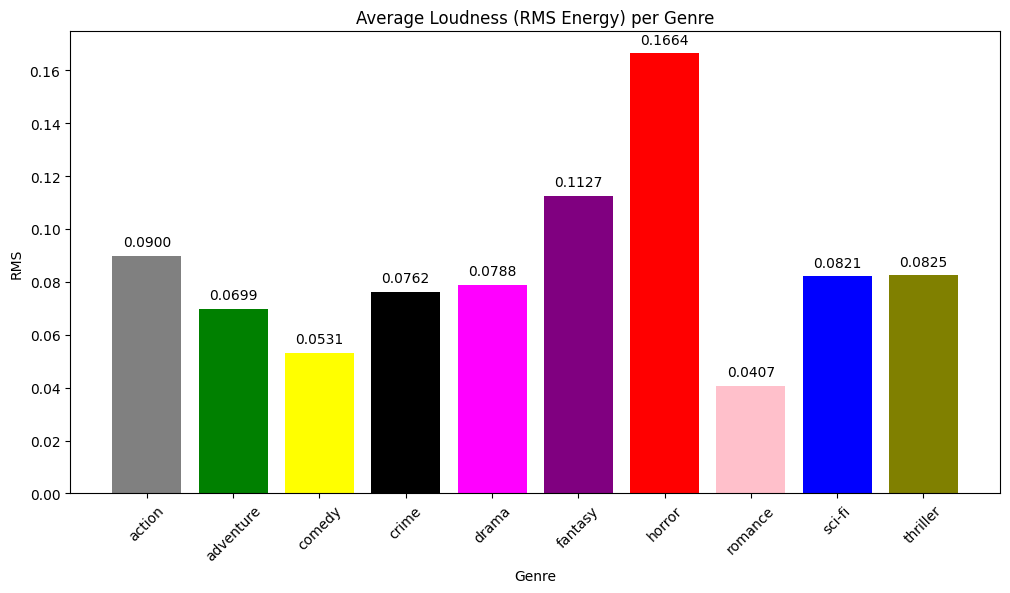

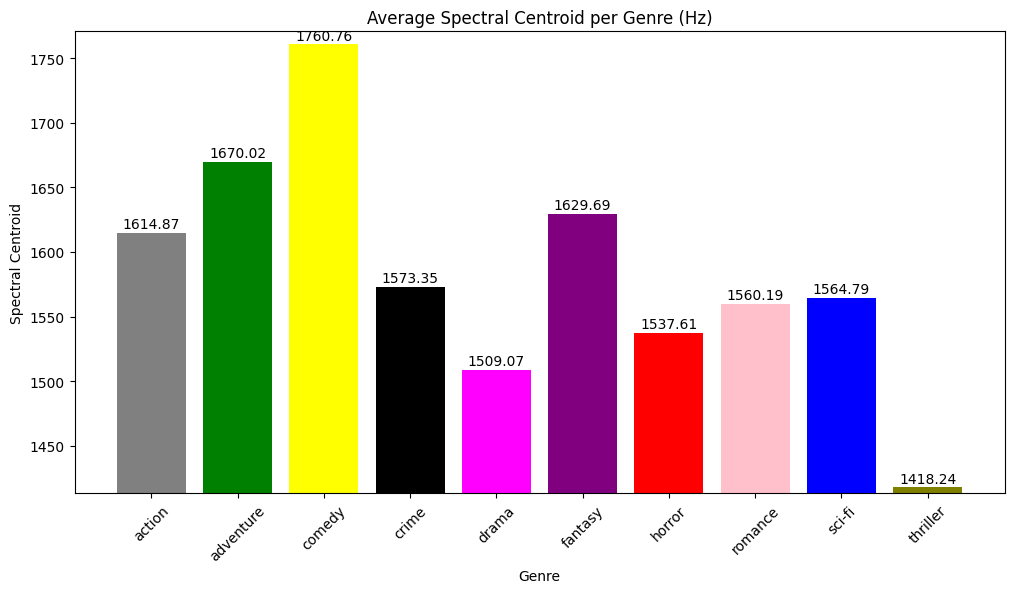

In [14]:
import matplotlib.pyplot as plt

result_dir = os.path.join('data', 'results')
os.makedirs(result_dir, exist_ok=True)

x = df_avg['genre_list'].astype(str).apply(lambda v: v if isinstance(v, str) else str(v))
y_tempo = df_avg['tempo'].apply(lambda v: v.item() if hasattr(v, "item") else v)
y_zcr = df_avg['zcr'].apply(lambda v: v.item() if hasattr(v, "item") else v)
y_rms = df_avg['rms'].apply(lambda v: v.item() if hasattr(v, "item") else v)
y_spectral_centroid = df_avg['spectral_centroid'].apply(lambda v: v.item() if hasattr(v, "item") else v)
bar_colors = ['gray', 'green', 'yellow', 'black', 'magenta', 'purple', 'red', 'pink', 'blue', 'olive']

# Tempo
plt.figure(figsize=(12,6))
plt.bar(x, y_tempo, color=bar_colors)
for i, v in enumerate(y_tempo):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
plt.ylim(min(y_tempo) - 5, max(y_tempo) + 10)
plt.xticks(rotation=45)
plt.title('Average Tempo per Genre (BPM)')
plt.xlabel('Genre')
plt.ylabel('Tempo')
plt.show()

# ZCR
offset_zcr = (max(y_zcr) - min(y_zcr)) * 0.02
plt.figure(figsize=(12,6))
plt.bar(x, y_zcr, color=bar_colors)
for i, v in enumerate(y_zcr):
    plt.text(i, v + offset_zcr, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
plt.ylim(min(y_zcr) - 0.02, max(y_zcr) + 0.01)

plt.xticks(rotation=45)
plt.title('Average Zero Crossing Rate per Genre (%)')
plt.xlabel('Genre')
plt.ylabel('Zero Crossing Rate (%)')
plt.show()


# RMS
offset_rms = (max(y_rms) - min(y_rms)) * 0.02
plt.figure(figsize=(12,6))
plt.bar(x, y_rms, color=bar_colors)
for i, v in enumerate(y_rms):
    plt.text(i, v + offset_rms, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
# plt.ylim(min(y_rms) - 0.01, max(y_rms) + 0.01)
plt.xticks(rotation=45)
plt.title('Average Loudness (RMS Energy) per Genre')
plt.xlabel('Genre')
plt.ylabel('RMS')
plt.show()

# Spectral Centroid
plt.figure(figsize=(12,6))
plt.bar(x, y_spectral_centroid, color=bar_colors)
for i, v in enumerate(y_spectral_centroid):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
plt.ylim(min(y_spectral_centroid) - 5, max(y_spectral_centroid) + 10)
plt.xticks(rotation=45)
plt.title('Average Spectral Centroid per Genre (Hz)')
plt.xlabel('Genre')
plt.ylabel('Spectral Centroid')
plt.show()

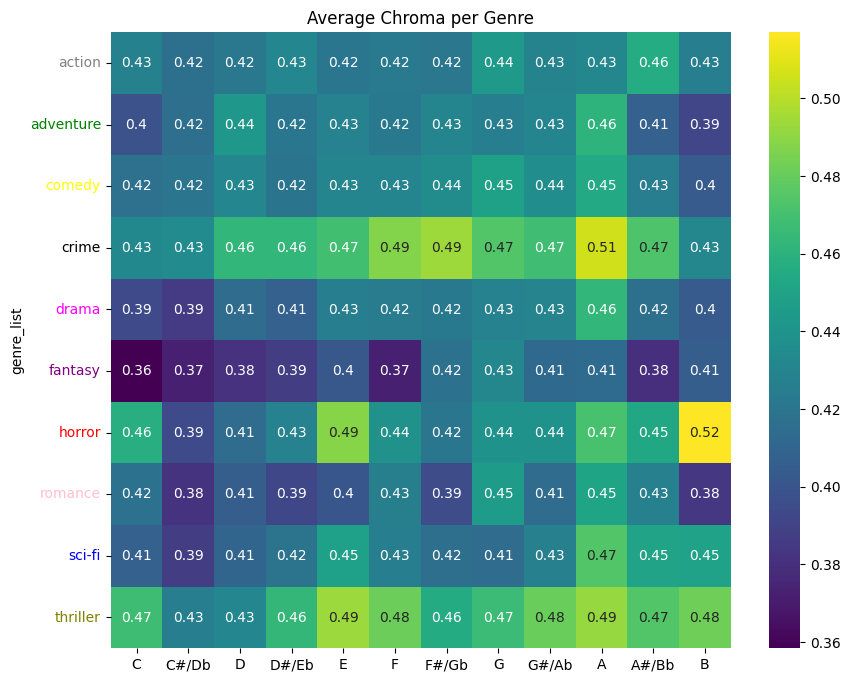

In [20]:
import seaborn as sns
chroma_cols = [col for col in df_avg.columns if col.startswith('chroma')]
chroma_meaning = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']

plt.figure(figsize=(10,8))
ax = sns.heatmap(df_avg.set_index('genre_list')[chroma_cols], annot=True, cmap='viridis', xticklabels=chroma_meaning)
plt.title('Average Chroma per Genre')

ax_ylabels = ax.get_yticklabels()

# Apply colors to y-tick labels
for label, color in zip(ax_ylabels, bar_colors):
    label.set_color(color)
plt.draw()
plt.show()
